In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import stable_baselines3
from portfolio_env_framework import *
import random
import torch
import torch.nn as nn
import numpy.typing as npt
import gymnasium as gym

In [2]:
class TrainDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Dict:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size+1, 100), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        s = np.zeros((3, self.universe_size+1, 100))
        # s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[0, :-1, :] = self.stock_df.loc[self.times[t:t+100], :].to_numpy().T
        s[1, :-1, :] = self.high_df.loc[self.times[t:t+100], :].to_numpy().T
        s[2, :-1, :] = self.low_df.loc[self.times[t:t+100], :].to_numpy().T
        s[:, -1, :] = 1.0
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_df.loc[self.times[t+100], :].to_numpy().flatten(), 1.0)

In [3]:
class DifferentialSharpeRatioReward(AbstractRewardManager):
    def __init__(self, eta: float = 1/252):
        self.eta = eta
        self.initialize_reward()

    def initialize_reward(self):
        self.A, self.B = 0.0, 0.0

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        R = np.log(new_port_val / old_port_val)
        dA = R - self.A
        dB = R ** 2 - self.B
        if self.B - self.A ** 2 == 0:
            D = 0
        else:
            D = (self.B * dA - 0.5 * self.A * dB) / (self.B - self.A ** 2) ** (3 / 2)
        self.A += self.eta * dA
        self.B += self.eta * dB
        return D

In [4]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        # return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size+1, 100), dtype=np.float32)
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(3, self.universe_size+1, 100), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        s = np.zeros((3, self.universe_size+1, 100))
        # s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[0, :-1, :] = self.stock_df.loc[self.times[t:t+100], :].to_numpy().T
        s[1, :-1, :] = self.high_df.loc[self.times[t:t+100], :].to_numpy().T
        s[2, :-1, :] = self.low_df.loc[self.times[t:t+100], :].to_numpy().T
        s[:, -1, :] = 1.0
        return {'data': s[None, :, :, :], 'weights': w[None, :]}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_df.loc[self.times[t+100], :].to_numpy().flatten(), 1.0)

## CNN Policy

In [5]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class Custom_EIEE_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 256):
        super(Custom_EIEE_Extractor, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size_w_rfa, data_len = observation_space['data'].shape
        n_output_channels = 32
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=(1, 5)),
            nn.ReLU(),
            nn.Conv2d(16, n_output_channels, kernel_size=(1, data_len-4)),
            nn.ReLU()
        ).cuda()

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        # print(f"inside extractor forward")
        x = self.cnn(observations['data'])
        w = observations['weights'][:, None, :]
        y = torch.cat((x.squeeze(-1), w), dim=1)
        return y

In [6]:
from stable_baselines3.common.policies import ActorCriticPolicy
from typing import Callable, Optional

class Custom_EIEE_Network(nn.Module):
    def __init__(self, observation_space: gym.spaces.Dict, last_layer_dim_pi: Optional[int] = None, last_layer_dim_vf: Optional[int] = None):
        super(Custom_EIEE_Network, self).__init__()
        universe_size_w_rfa = observation_space['data'].shape[1]
        self.latent_dim_pi = universe_size_w_rfa if last_layer_dim_pi is None else last_layer_dim_pi
        self.latent_dim_vf = universe_size_w_rfa if last_layer_dim_vf is None else last_layer_dim_vf
        self.policy_net = nn.Sequential(
            nn.Linear(33, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        self.value_net = nn.Sequential(
            nn.Linear(33, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        self.v_policy_net = torch.vmap(torch.vmap(self.policy_net))
        self.v_value_net = torch.vmap(torch.vmap(self.value_net))

    def forward(self, features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        return self.forward_actor(features), self.forward_critic(features)

    def forward_actor(self, features: torch.Tensor) -> torch.Tensor:
        x = self.v_policy_net(torch.transpose(features, 1, 2)).squeeze(-1)
        # print(f"{x.shape=}")
        # print(f"{nn.functional.softmax(x, dim=1).sum(axis=1).shape=}")
        # print(f"{nn.functional.softmax(x, dim=1).sum(axis=1)=}")
        # print(f"actor {nn.functional.softmax(x, dim=1)=}")
        return nn.functional.softmax(x, dim=1)
        # return x

    def forward_critic(self, features: torch.Tensor) -> torch.Tensor:
        x = self.v_value_net(torch.transpose(features, 1, 2)).squeeze(-1)
        # print(f"critic {nn.functional.softmax(x, dim=1)=}")
        return nn.functional.softmax(x, dim=1)
        # return x

class Custom_EIEE_AC_Policy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        *args,
        **kwargs,
    ):
        # Disable orthogonal initialization
        kwargs["ortho_init"] = False
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = Custom_EIEE_Network(self.observation_space)

In [7]:
# Parallel environments
from stable_baselines3 import DDPG, SAC


train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.01, cs=0.01)
# vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
#     'dm': TrainDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.01, # 0.10/365,
#     'cs': 0.01, # 0.10/365
# })

# Set seeds
random.seed(42)
np.random.seed(42)
# train_env.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO(Custom_EIEE_AC_Policy, train_env, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_Extractor,
})
model.learn(total_timesteps=100_000)
# model.save("cnn_portoflio_policy")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 119  |
|    iterations      | 1    |
|    time_elapsed    | 17   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.41e+03    |
|    ep_rew_mean          | -232        |
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 2           |
|    time_elapsed         | 37          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017333629 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | -6.2e-06    |
|    learning_rate        | 0.0003      |
|    loss              

In [17]:
type(model).__mro__

(stable_baselines3.ppo.ppo.PPO,
 stable_baselines3.common.on_policy_algorithm.OnPolicyAlgorithm,
 stable_baselines3.common.base_class.BaseAlgorithm,
 abc.ABC,
 object)

In [9]:
np.array(list(map(lambda a: (a == actions[0]).all(), actions))).all()

False

In [8]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    rm=DifferentialSharpeRatioReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+100]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+100])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+100]].vwretd.values[0]))
    if terminated:
        break

external action=array([[ 0.0492435 , -0.10648905, -0.04844498,  0.03736299,  0.08493491,
        -0.04448066,  0.15534665,  0.14403187, -0.1598392 , -0.06626271,
         0.12912619, -0.00065842,  0.0655429 , -0.01267773, -0.08904777,
        -0.05565817,  0.06296155, -0.01139727, -0.19019851, -0.19216809,
        -0.118376  , -0.06364973,  0.0102177 , -0.06528659, -0.13405904,
        -0.14663693,  0.03536797, -0.01551292, -0.02619408,  0.04493143,
        -0.09635384, -0.11957535,  0.09428991, -0.13038556, -0.03725242,
         0.07652413, -0.05352795, -0.07081415,  0.07970107, -0.11410081,
        -0.00054395, -0.09605058,  0.23983696,  0.07928159,  0.0566473 ,
        -0.10655825, -0.02875523,  0.04855583,  0.11655086, -0.03883867,
        -0.17539519, -0.02322053,  0.05397349, -0.05157007, -0.16410267,
        -0.22351947, -0.16613652,  0.10902959,  0.10326062,  0.02189744,
         0.03917812,  0.10271102,  0.02776136,  0.02761704, -0.14502652,
         0.02349335, -0.18917227,  

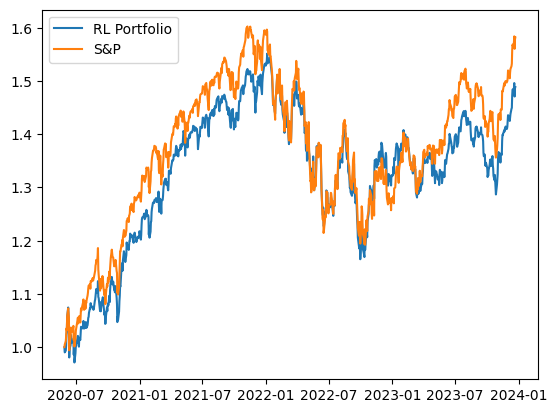

In [10]:
# idk2 (1, 2) softmax
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

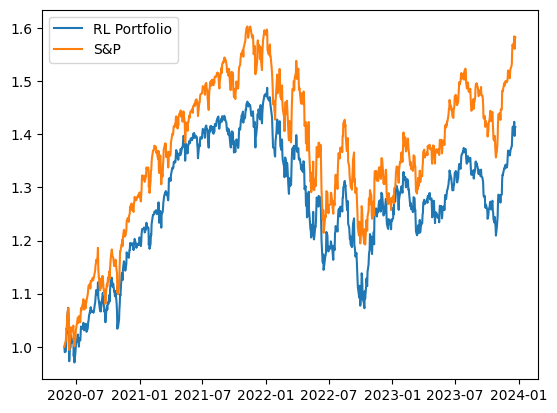

In [10]:
# idk2 (-20, 20)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

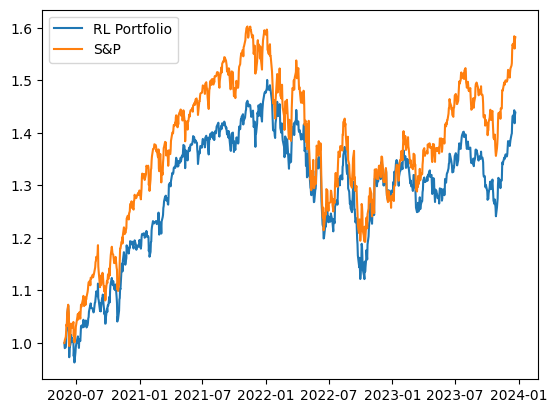

In [10]:
# idk2 (-1, 2)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

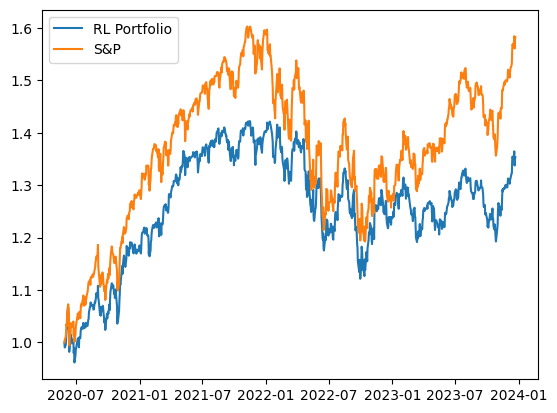

In [10]:
# idk
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

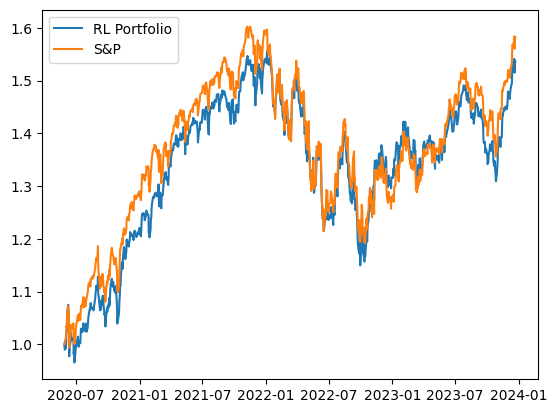

In [ ]:
# softmax 0
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

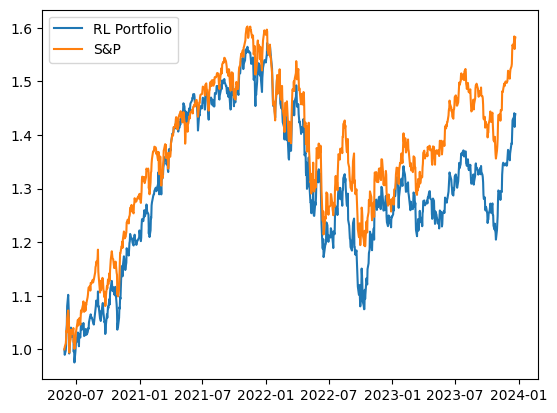

In [ ]:
# softmax 1
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# original
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

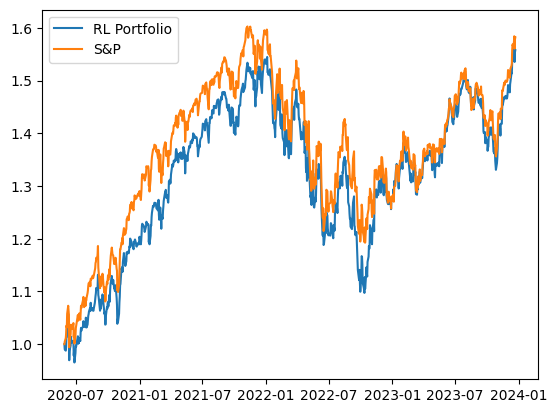

In [ ]:
# original
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

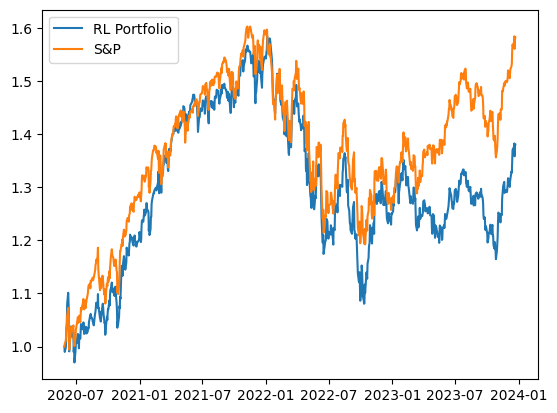

In [ ]:
# modified batched
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

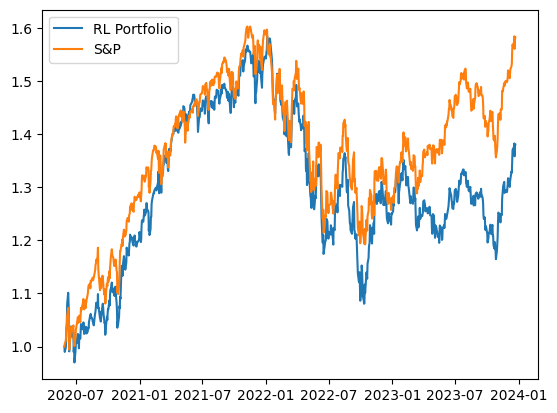

In [ ]:
# modified unbatched
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

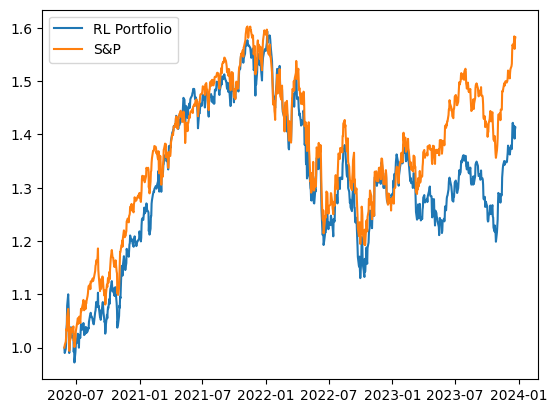

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

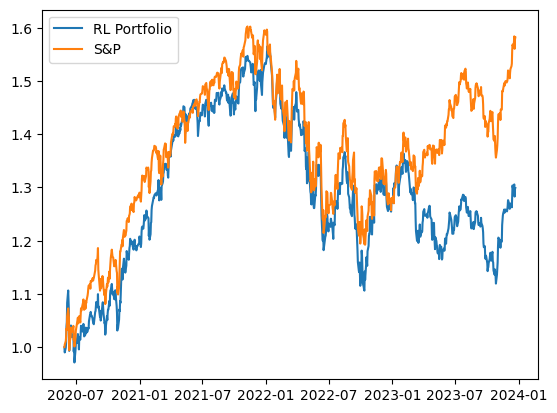

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

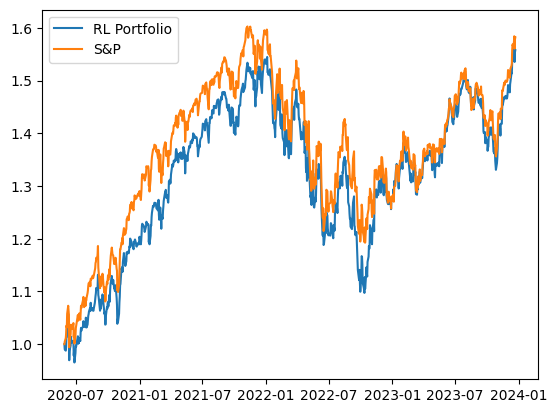

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

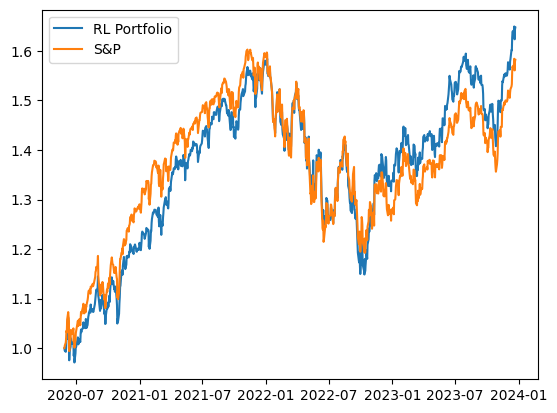

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

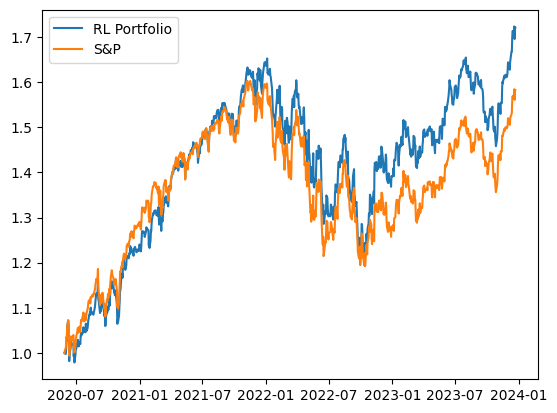

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

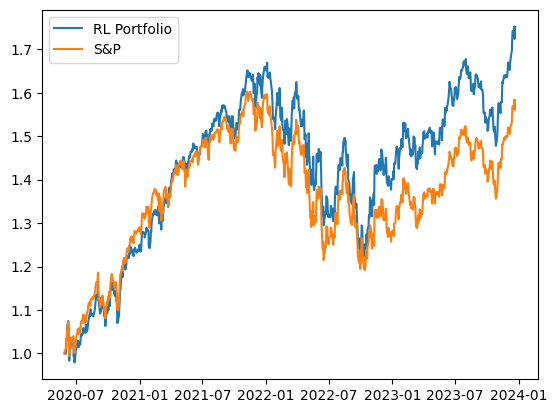

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

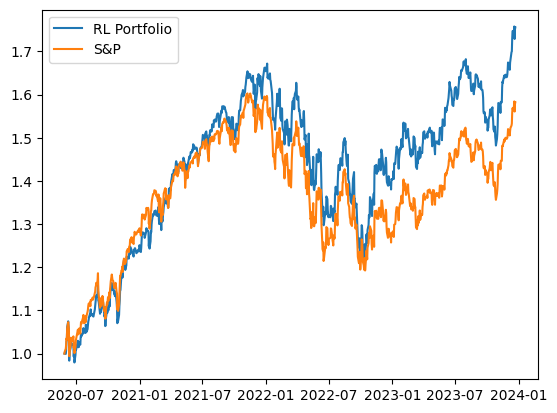

In [ ]:
plt.plot(times_arr, np.array(port_val) / np.array([1, *mus]).cumprod(), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
np.array(mus).min(), np.array(mus).max(), np.array(mus).mean()

(0.9997260273972602, 0.9999989851403436, 0.999996785882278)

## RNN Policy

In [ ]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class Custom_EIEE_Extractor_RNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 256):
        super(Custom_EIEE_Extractor_RNN, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size_w_rfa, data_len = observation_space['data'].shape
        n_output_channels = 32
        self.rnn = nn.RNN(input_size=n_channels, hidden_size=n_output_channels, num_layers=10, batch_first=True).cuda()
        # n_flatten = np.prod(self.cnn(torch.as_tensor(observation_space.sample()[None]).permute(0, 2, 1)).shape)
        # self.linear = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(n_flatten, features_dim),
        #     nn.ReLU()
        # )

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        # print(f"{type(observations)=}")
        # print(f"{type(observations['data'])=}")
        # print(f"{observations['data'].shape=}")
        # print(f"{observations=}")
        assert len(observations['data'].shape) == 4 # (4, 3, 85, 100)
        obs = torch.permute(observations['data'], (0, 2, 3, 1)) # (4, 85, 100, 3)
        obs = obs.flatten(0, 1)
        # print(f"{obs.shape=}")
        x = self.rnn(obs)
        # x = self.rnn(obs)
        # print(f"{type(x)=}")
        # print(f"{x[0].shape=}")
        # print(f"{x[1].shape=}")
        # print(f"{x[1][-1].shape=}")
        x = x[1][-1].unflatten(0, (x[1][-1].shape[0] // self.universe_size_w_rfa, self.universe_size_w_rfa))
        # print(f"{x.shape=}")
        # print(f"{x=}")
        # print(f"{x.squeeze().shape=}")
        w = observations['weights'][:, None, :]
        # print(f"{w.shape=}")
        y = torch.cat((x.squeeze(-1).transpose(1, 2), w), dim=1)
        # print(f"{y.shape=}")
        return y
        # return torch.tensor([1.0, 1.5, 2])

In [ ]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': TrainDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO(Custom_EIEE_AC_Policy, vec_env, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_Extractor_RNN,
})
model.learn(total_timesteps=100_000)
# model.save("cnn_portoflio_policy")

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 243  |
|    iterations      | 1    |
|    time_elapsed    | 33   |
|    total_timesteps | 8192 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.41e+03   |
|    ep_rew_mean          | 6.65e+03   |
| time/                   |            |
|    fps                  | 93         |
|    iterations           | 2          |
|    time_elapsed         | 174        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.10642598 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.2        |
|    entropy_loss         | -121       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 2.66       |
|    n_updates            | 10         |
|    policy_gradient_loss | 0.0681

In [ ]:
env = PortfolioEnvWithTCost(dm=TestDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.10/365, cs=0.10/365)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+100]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+100])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+100]].vwretd.values[0]))
    if terminated:
        break

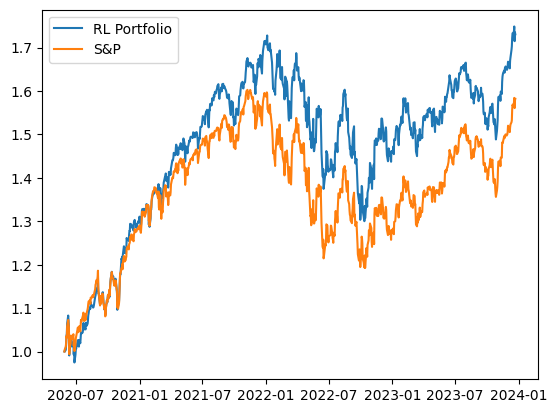

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

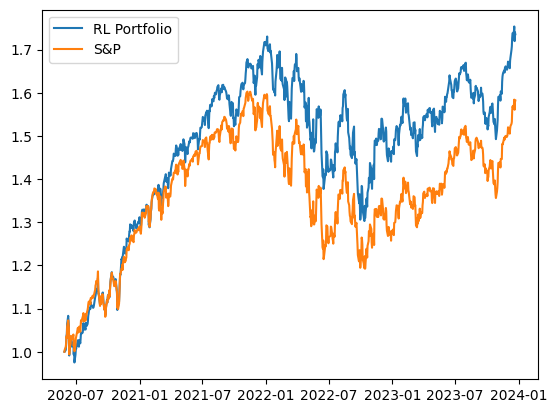

In [ ]:
plt.plot(times_arr, np.array(port_val) / np.array([1, *mus]).cumprod(), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## Comparison Plot

In [ ]:
rnn_model = model

In [ ]:
rnn_port_val = port_val
rnn_snp_val = snp_val

In [ ]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': TrainDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO(Custom_EIEE_AC_Policy, vec_env, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_Extractor,
})
model.learn(total_timesteps=100_000)
# model.save("cnn_portoflio_policy")

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 234  |
|    iterations      | 1    |
|    time_elapsed    | 34   |
|    total_timesteps | 8192 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.41e+03   |
|    ep_rew_mean          | 6.24e+03   |
| time/                   |            |
|    fps                  | 196        |
|    iterations           | 2          |
|    time_elapsed         | 83         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.10303955 |
|    clip_fraction        | 0.654      |
|    clip_range           | 0.2        |
|    entropy_loss         | -121       |
|    explained_variance   | -2.38e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 2.62       |
|    n_updates            | 10         |
|    policy_gradient_loss | 0.0665

In [ ]:
cnn_model = model

In [ ]:
env = PortfolioEnvWithTCost(dm=TestDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.10/365, cs=0.10/365)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+100]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+100])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+100]].vwretd.values[0]))
    if terminated:
        break

In [ ]:
cnn_port_val = port_val
cnn_snp_val = snp_val

In [ ]:
class BasicDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.vol_20 = idx_df.vol_20
        self.vol_60 = idx_df.vol_60
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix_df = vix_df.vix
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = w
        # s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[:-1, 1:] = self.ret.loc[self.times[t:t+100], :].to_numpy().T # 100 past returns, up to yesterday
        s[-1, 1] = self.vol_20[self.times[t+100-1]] # yesterday's vol_20
        s[-1, 2] = self.vol_20[self.times[t+100-1]] / self.vol_60[self.times[t+100-1]] # yesterday's vol ratio
        s[-1, 3] = self.vix_df[self.times[t+100-1]] # yesterday's vix
        return s

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_df.loc[self.times[t+100], :].to_numpy().flatten(), 1.0)

In [ ]:
class DifferentialSharpeRatioReward(AbstractRewardManager):
    def __init__(self, eta: float = 1/252):
        self.eta = eta
        self.initialize_reward()

    def initialize_reward(self):
        self.A, self.B = 0.0, 0.0

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        R = np.log(new_port_val / old_port_val)
        dA = R - self.A
        dB = R ** 2 - self.B
        if self.B - self.A ** 2 == 0:
            D = 0
        else:
            D = (self.B * dA - 0.5 * self.A * dB) / (self.B - self.A ** 2) ** (3 / 2)
        self.A += self.eta * dA
        self.B += self.eta * dB
        return D

In [ ]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': BasicDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework")

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 439  |
|    iterations      | 1    |
|    time_elapsed    | 18   |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.41e+03    |
|    ep_rew_mean          | 6.54e+03    |
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 2           |
|    time_elapsed         | 50          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.026101425 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 2.08e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.234       |
|    n_updates            | 10          |
|    policy_grad

In [ ]:
class TestBasicDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        self.vol_20 = idx_df.vol_20
        self.vol_60 = idx_df.vol_60
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix_df = vix_df.vix
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = w
        # s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[:-1, 1:] = self.ret.loc[self.times[t:t+100], :].to_numpy().T # 100 past returns, up to yesterday
        s[-1, 1] = self.vol_20[self.times[t+100-1]] # yesterday's vol_20
        s[-1, 2] = self.vol_20[self.times[t+100-1]] / self.vol_60[self.times[t+100-1]] # yesterday's vol ratio
        s[-1, 3] = self.vix_df[self.times[t+100-1]] # yesterday's vix
        return s

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_df.loc[self.times[t+100], :].to_numpy().flatten(), 1.0)

In [ ]:
env = PortfolioEnvWithTCost(dm=TestBasicDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.10/365, cs=0.10/365)
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+100]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+100])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+100]].vwretd.values[0]))
    if terminated:
        break

In [ ]:
mlp_port_val = port_val
mlp_snp_val = snp_val

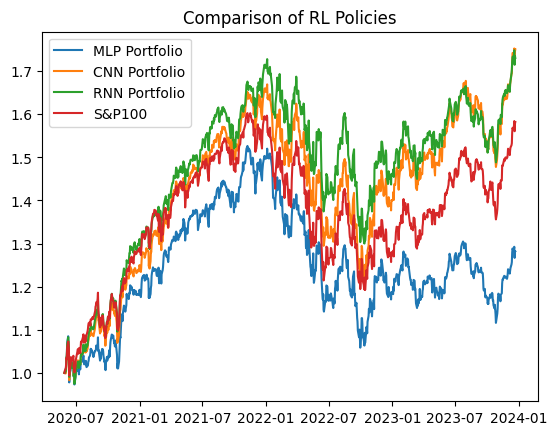

In [ ]:
plt.plot(times_arr, np.array(mlp_port_val), label='MLP Portfolio')
plt.plot(times_arr, np.array(cnn_port_val), label='CNN Portfolio')
plt.plot(times_arr, np.array(rnn_port_val), label='RNN Portfolio')
plt.plot(times_arr, np.array(mlp_snp_val), label='S&P100')
plt.title('Comparison of RL Policies')
plt.legend()
plt.show()